In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import json
import sys
import re
import logging
import os
import re
from pathlib import Path
from functools import partial, cache, cached_property
from itertools import chain
from inspect import signature
from uuid import uuid4

import blpapi
import ipywidgets as w
import ipyvuetify as v
import numpy as np
import pandas as pd
import QuantLib as ql
import talib as ta 
from IPython.display import display
from ipydatagrid import DataGrid, TextRenderer, BarRenderer, Expr, VegaExpr
from bqplot import LinearScale, ColorScale, OrdinalColorScale, OrdinalScale
from pandas.tseries.offsets import BDay
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import ParameterGrid
from termcolor import colored
from joblib import Parallel, delayed
# from bhsysapi import BHSysApi

from techi import api as ti

from gioutils import ezutils as ez
from gioutils.ezutils import bh, bhs
from gioutils.blpw import BlpQuery
from gioutils.gui.pandas import millify
from gioutils.utils import (
    RepeatedTimer, 
    parse_swap_tenor_expr, 
    parse_offset,
    today, 
    get_next_n, 
    get_n_from_code,
    date_from_offset, 
    get_bday,
    get_bbg_fut_chain_ticker
)

from api.data.base import data_path, radar_path
from api.gui.params import bbg_params, spot_params, fwd_params
from api.instruments.swap import RealSwap, RollingSwap, Fly, Spread
from api.instruments.utils import parse_dates, parse_number, ez_bump
from api.instruments.strategies import FutureStrategy
from api.instruments.signals import MACDHistCrossover, ZScoreThreshold, EnsambleSignal
from api.instruments.cache import data_cache
from api.instruments.future import FutureChain, FutureSpread, FutureFly
from api.gui.theme import bg_color, grid_style
from api.gui.pandas import DFOutput, negative_red, custom_styler_row_line, DataGridGio
from api.instruments import config as c
from api.instruments.signals2 import BaseSignal, MACDCustomSignal, get_crossover_signal
from api.instruments.strategies2 import MACDCustomStrategy

In [37]:
pd.options.plotting.backend = "plotly"
pd.options.display.float_format = millify
c.USE_T_COST = True

In [38]:
bq = BlpQuery(timeout=50000).start()
# ba = BHSysApi(password="A&3jg5Aj")

In [39]:
notional = 1000
hist = '10y'
strategy_hist = '1y'

## Instruments Parameters

In [40]:
rates = [
    'ed',
    'er',
    'sfr',
    'ff',
]

govt = [
    'tu',
    'fv',
    'ty',
    'us',
    'du',
    'oe',
    'rx',
    'ub',
    'ik'
]

In [42]:
FutureChain('sfr1').symbol

'SFR1 R:05_0_D Comdty'

In [7]:
rates_single_legs = range(1, 12 + 1)
govt_single_legs = range(1, 2 + 1)

fly_legs = [
    (2, 3, 4),
    (2, 4, 6),
    (2, 5, 8),
    (2, 6, 10),
    (2, 7, 12),
    (3, 4, 5),
    (3, 5, 7),
    (3, 6, 9),
    (3, 7, 11),
    (3, 8, 13),
    (4, 6, 8),
    (4, 7, 9),
    (4, 7, 11),
    (4, 8, 12),
    (5, 8, 11),
    (5, 9, 13),
    (6, 9, 12),
]

spread_legs = [
    (2, 3),
    (2, 4),
    (2, 5),
    (2, 6),
    (2, 7),
    (2, 8),
    (2, 9),
    (3, 5),
    (3, 6),
    (3, 7),
    (3, 8),
    (3, 9),
    (3, 10),
    (3, 11),
    (3, 12),
    (4, 6),
    (4, 7),
    (4, 8),
    (4, 9),
    (4, 10),
    (4, 11),
    (4, 12),
    (5, 8),
    (5, 9),
    (5, 10),
    (5, 11),
    (5, 12),
    (6, 8),
    (6, 9),
    (6, 10),
    (6, 11),
    (6, 12),
    (7, 10),
    (7, 11),
    (7, 12),
    (8, 12),
]

In [8]:
steps = dict(
    fastperiod=1,
    slowperiod=1,
    signalperiod=1,
    time_barrier=1,
    q=0.1,
    k=0.1,
    crossover_days=1,
    signal_threshold_buy=10,
    signal_threshold_sell=10,
    base_stop_periods=1,
    base_stop_mult=1,
)

In [9]:
macd_params = {
    'fastperiod': np.arange(12, 12 + steps['fastperiod'], steps['fastperiod']).tolist(),
    'slowperiod': np.arange(26, 26 + steps['slowperiod'], steps['slowperiod']).tolist(),
    'signalperiod': np.arange(9, 9 + steps['signalperiod'], steps['signalperiod']).tolist(),
}

strategy_params = {
    'time_barrier': np.arange(4, 5 + steps['time_barrier'], steps['time_barrier']).tolist(),
    'q': np.arange(0.4, 0.9 + steps['q'], steps['q']).round(int(np.abs(np.log10(steps['q'])))).tolist(),
    'k': np.arange(2, 3 + steps['k'], steps['k']).round(int(np.abs(np.log10(steps['k'])))).tolist(),
    'crossover_days': np.arange(3,  3 + steps['crossover_days'], steps['crossover_days']).tolist(),
    'base_stop_periods': np.arange(7,  7 + steps['base_stop_periods'], steps['base_stop_periods']).tolist(),
    'base_stop_mult': np.arange(2,  2 + steps['base_stop_mult'], steps['base_stop_mult']).tolist(),
}

In [10]:
macd_dynamic_params = [
    'signal_threshold_buy',
    'signal_threshold_sell',
    'slope_threshold_buy',
    'slope_threshold_sell',
]

In [11]:
macd_param_grid = ParameterGrid(macd_params)

In [12]:
signal_threshold_quantile1 = .75
signal_threshold_quantile2 = .99
slope_threshold_quantiles = [
    0.3, 
    # 0.4, 
    # 0.5
]

In [13]:
def series_fn(instrument):
    return 100 - instrument.yld

### Govt

In [14]:
def make_param_grids(
    instrument,
    macd_param_grid, 
    signal_threshold_quantile1=.75,
    signal_threshold_quantile2=.99,
    slope_threshold_quantiles=None,
    notional=1000,
    start_hist='10y',
):
    slope_threshold_quantiles = slope_threshold_quantiles or [
        0.3, 
        # 0.4, 
        # 0.5
    ]
    instrument_param_grids = []
    for macd_param in macd_param_grid:
        signal = MACDCustomSignal(ti_kwargs=macd_param, series_fn='price_yld')
        data_ = signal.get_data(instrument)

        signal_threshold_buy = np.linspace(
            data_['macd'].quantile(1 - signal_threshold_quantile2),
            data_['macd'].quantile(1 - signal_threshold_quantile1), 
            num=steps['signal_threshold_buy']
        ).round(int(np.abs(np.log10(instrument.tick_size))))
        signal_threshold_sell = np.linspace(
            data_['macd'].quantile(signal_threshold_quantile2), 
            data_['macd'].quantile(signal_threshold_quantile1), 
            num=steps['signal_threshold_sell']
        ).round(int(np.abs(np.log10(instrument.tick_size))))

        slope_threshold_buy = [0, *data_.loc[data_['slope'] > 0, 'slope'].quantile(slope_threshold_quantiles).round(2 * int(np.abs(np.log10(instrument.tick_size))))]
        slope_threshold_sell = [0, *data_.loc[data_['slope'] < 0, 'slope'].quantile([*reversed(slope_threshold_quantiles)]).round(2 * int(np.abs(np.log10(instrument.tick_size))))]

        signal_dynamic_params_ = {
            'signal_threshold_buy': signal_threshold_buy,
            'signal_threshold_sell': signal_threshold_sell,
            'slope_threshold_buy': slope_threshold_buy,
            'slope_threshold_sell': slope_threshold_sell,
        }

        new_params = {
            **{k: [macd_param[k]] for k in macd_param},
            **signal_dynamic_params_,
            **strategy_params,
        }

        instrument_param_grids.append(ParameterGrid(new_params))
    return instrument_param_grids

In [15]:
rank_weight = pd.Series(
    {
        'std': -1,
        # 'var': 1,
        'cond_var': 1,
        'median': 1,
        'mean': 1,
        'sharpe_ratio': 1,
        'hit_ratio': 1,
        'drawdown': -1,
        'pnl': 1,
    }
)

In [17]:
def run_one(
    ticker,
    rank_weight,
    macd_param_grid,
    contract=1, 
    notional=1000,
    start_hist='10y',
    strategy_start_hist='1y',
    signal_threshold_quantile1=.75,
    signal_threshold_quantile2=.99,
    slope_threshold_quantiles=None,
    save_max=1000, 
    stop=None,
    stop2=None,
):
    c.USE_T_COST = True
    stats = {}
    strategies = {}
    symbol = f"{ticker}{contract}"
    instrument = FutureChain(
        ticker=symbol,
        notional=notional,
        start_hist=start_hist
    )
    
    instrument_param_grids = make_param_grids(
        instrument=instrument,
        macd_param_grid=macd_param_grid,
        signal_threshold_quantile1=signal_threshold_quantile1,
        signal_threshold_quantile2=signal_threshold_quantile2,
        slope_threshold_quantiles=slope_threshold_quantiles,
        notional=notional,
        start_hist=start_hist,
    )
    stop = stop or len(instrument_param_grids)
    total = min(stop, len(instrument_param_grids)) * len(instrument_param_grids[0])
    
    for j, param in enumerate(chain.from_iterable(instrument_param_grids[:stop])):
        signal_params = {
            **{k: param[k] for k in macd_dynamic_params},
            'ti_kwargs': {k: param[k] for k in macd_params},
        }
        signal = MACDCustomSignal(**signal_params, series_fn='price_yld')

        custom_strategy_params = {k: param[k] for k in strategy_params}
        strategy = MACDCustomStrategy(
            instrument=instrument,
            signal=signal,
            start_hist=strategy_start_hist,
            **custom_strategy_params
        )
        print(strategy.instrument.t_cost)
        strategy.run()
        if hasattr(strategy, '_summary'):
            strategies[j] = strategy
            stats[j] = strategy.stats
            if len(strategies) > save_max:
                stats_ = pd.DataFrame(stats).T
                ranks_ = (stats_ * rank_weight).rank().mean(axis=1).sort_values(ascending=False)
                to_drop = ranks_.index[-1]
                strategies.pop(to_drop)
                stats.pop(to_drop)
            print(
                f'{millify(j + 1)}/{millify(total)}', 
                ticker.upper(), 
                # {**signal_params, **custom_strategy_params}, 
                'PV',
                millify(strategy._summary['pv'].iloc[-1]),
                '    ',
                end="\r"
            )
            if j == stop2:
                break
            
    stats = pd.DataFrame(stats).T 
    order = (stats * rank_weight).rank().mean(axis=1).sort_values(ascending=False).index
    stats = stats.loc[order, :]
    strategies = pd.Series(strategies).loc[order]
    return stats, strategies, instrument_param_grids, symbol

In [26]:
res = Parallel(
    n_jobs=-1,
    verbose=100,
    # backend='multiprocessing'
)(
    delayed(run_one)(
        ticker=ticker, 
        macd_param_grid=macd_param_grid,
        rank_weight=rank_weight,
        contract=1,  
        stop2=1,
    ) for ticker in ['rx']
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.3s finished


In [27]:
ress = {r[-1]: [*r[:-1]] for r in res}

In [28]:
ress.keys()

dict_keys(['rx1'])

In [31]:
key = 'rx'

In [32]:
ress[f'{key}1'][1].iloc[0].instrument.t_cost

3.5

In [33]:
ress[f'{key}1'][1].iloc[0]._data.loc[ress[f'{key}1'][1].iloc[0]._pnl.index, :]

macd  macdsignal  macdhist   slope  slope_chg  signal  \
date                                                                   
2022-06-22 -21.331%    -19.393%   -1.938%  1.359%       1.00    1.00   
2022-06-23 -18.028%    -19.120%    1.092%  3.302%          0       0   
2022-08-03  17.585%     14.599%    2.986% -0.484%       1.00   -1.00   
2022-08-04  17.595%     15.198%    2.397%  0.010%       1.00       0   
2022-08-05  16.167%     15.392%    0.775% -1.429%       1.00   -1.00   
2022-08-08  15.349%     15.383%   -0.034% -0.817%          0       0   
2022-09-30 -22.669%    -20.818%   -1.851%  0.621%       1.00    1.00   
2022-10-03 -20.001%    -20.655%    0.653%  2.667%          0       0   
2022-10-14 -19.165%    -18.709%   -0.456%  0.080%       1.00    1.00   
2022-10-17 -18.294%    -18.626%    0.332%  0.871%          0       0   

            crossover  quote  trade  signal  entry_price  quote_chg  \
date                                                                  
2022-06-22          0 142.14   1.00    1.00       142.17    -3.500%   
2022-06-23       1.00 145.05   1.00    1.00          NaN       2.88   
2022-08-03          0 153.82   2.00   -1.00       153.78    -3.500%   
2022-08-04          0 154.76   2.00   -1.00          NaN   -94.000%   
2022-08-05          0 152.80   2.00   -1.00          NaN       1.96   
2022-08-08      -1.00 153.57   2.00   -1.00          NaN   -80.500%   
2022-09-30          0 137.77   3.00    1.00       137.81    -3.500%   
2022-10-03       1.00 140.46   3.00    1.00          NaN       2.66   
2022-10-14          0 135.36   4.00    1.00       135.40    -3.500%   
2022-10-17       1.00 136.16   4.00    1.00          NaN    76.500%   

            stop_loss  take_profit  exit_price      pnl      pv  quote_chg_cum  
date                                                                            
2022-06-22       2.22         2.22         NaN  -35.00k -35.00k        -3.500%  
2022-06-23       1.16         2.33      145.02    2.88m   2.84m           2.84  
2022-08-03       2.00         2.00         NaN  -35.00k   2.81m        -3.500%  
2022-08-04       2.00         2.00         NaN -940.00k   1.87m       -97.500%  
2022-08-05       2.00         2.00         NaN    1.96m   3.83m        98.500%  
2022-08-08    10.000%      20.000%      153.60 -805.00k   3.02m        18.000%  
2022-09-30       2.00         2.00         NaN  -35.00k   2.99m        -3.500%  
2022-10-03       1.08         2.15      140.43    2.66m   5.64m           2.62  
2022-10-14       1.67         1.67         NaN  -35.00k   5.61m        -3.500%  
2022-10-17    32.000%      64.000%      136.12  765.00k   6.37m        73.000%

In [34]:
ress[f'{key}1'][1].iloc[0]._pnl

trade  signal  entry_price  quote_chg  stop_loss  take_profit  \
date                                                                        
2022-06-22      1    1.00       142.17    -3.500%       2.22         2.22   
2022-06-23      1    1.00          NaN       2.88       1.16         2.33   
2022-08-03      2   -1.00       153.78    -3.500%       2.00         2.00   
2022-08-04      2   -1.00          NaN   -94.000%       2.00         2.00   
2022-08-05      2   -1.00          NaN       1.96       2.00         2.00   
2022-08-08      2   -1.00          NaN   -80.500%    10.000%      20.000%   
2022-09-30      3    1.00       137.81    -3.500%       2.00         2.00   
2022-10-03      3    1.00          NaN       2.66       1.08         2.15   
2022-10-14      4    1.00       135.40    -3.500%       1.67         1.67   
2022-10-17      4    1.00          NaN    76.500%    32.000%      64.000%   

            exit_price      pnl      pv  quote_chg_cum  
date                                                    
2022-06-22         NaN  -35.00k -35.00k        -3.500%  
2022-06-23      145.02    2.88m   2.84m           2.84  
2022-08-03         NaN  -35.00k   2.81m        -3.500%  
2022-08-04         NaN -940.00k   1.87m       -97.500%  
2022-08-05         NaN    1.96m   3.83m        98.500%  
2022-08-08      153.60 -805.00k   3.02m        18.000%  
2022-09-30         NaN  -35.00k   2.99m        -3.500%  
2022-10-03      140.43    2.66m   5.64m           2.62  
2022-10-14         NaN  -35.00k   5.61m        -3.500%  
2022-10-17      136.12  765.00k   6.37m        73.000%

In [55]:
ress['rx1'][1]

0        <api.instruments.strategies2.MACDCustomStrateg...
19225    <api.instruments.strategies2.MACDCustomStrateg...
4824     <api.instruments.strategies2.MACDCustomStrateg...
4817     <api.instruments.strategies2.MACDCustomStrateg...
4816     <api.instruments.strategies2.MACDCustomStrateg...
                               ...                        
58       <api.instruments.strategies2.MACDCustomStrateg...
67       <api.instruments.strategies2.MACDCustomStrateg...
4875     <api.instruments.strategies2.MACDCustomStrateg...
14450    <api.instruments.strategies2.MACDCustomStrateg...
59       <api.instruments.strategies2.MACDCustomStrateg...
Length: 1000, dtype: object

In [65]:
ress['rx1'][1].iloc[999]._pnl

trade  signal  entry_price  quote_chg  stop_loss  take_profit  \
date                                                                        
2022-06-22      1    1.00       142.17    -3.500%       2.22         2.22   
2022-06-23      1    1.00          NaN       2.88       1.16         2.33   
2022-08-05      2   -1.00       152.77    -3.500%       2.22         2.22   
2022-08-08      2   -1.00          NaN   -80.500%       2.22         2.22   
2022-09-30      3    1.00       137.81    -3.500%       2.00         2.00   
2022-10-03      3    1.00          NaN       2.66       1.08         2.15   
2022-10-14      4    1.00       135.40    -3.500%       1.67         1.67   
2022-10-17      4    1.00          NaN    76.500%    32.000%      64.000%   
2022-12-09      5   -1.00       140.49    -3.500%       1.64         1.64   
2022-12-12      5   -1.00          NaN     0.500%     1.600%       3.200%   

            exit_price      pnl      pv  quote_chg_cum  
date                                                    
2022-06-22         NaN  -35.00k -35.00k        -3.500%  
2022-06-23      145.02    2.88m   2.84m           2.84  
2022-08-05         NaN  -35.00k   2.81m        -3.500%  
2022-08-08      153.60 -805.00k   2.00m       -84.000%  
2022-09-30         NaN  -35.00k   1.97m        -3.500%  
2022-10-03      140.43    2.66m   4.62m           2.62  
2022-10-14         NaN  -35.00k   4.59m        -3.500%  
2022-10-17      136.12  765.00k   5.35m        73.000%  
2022-12-09         NaN  -35.00k   5.32m        -3.500%  
2022-12-12      140.51    5.00k   5.32m        -3.000%

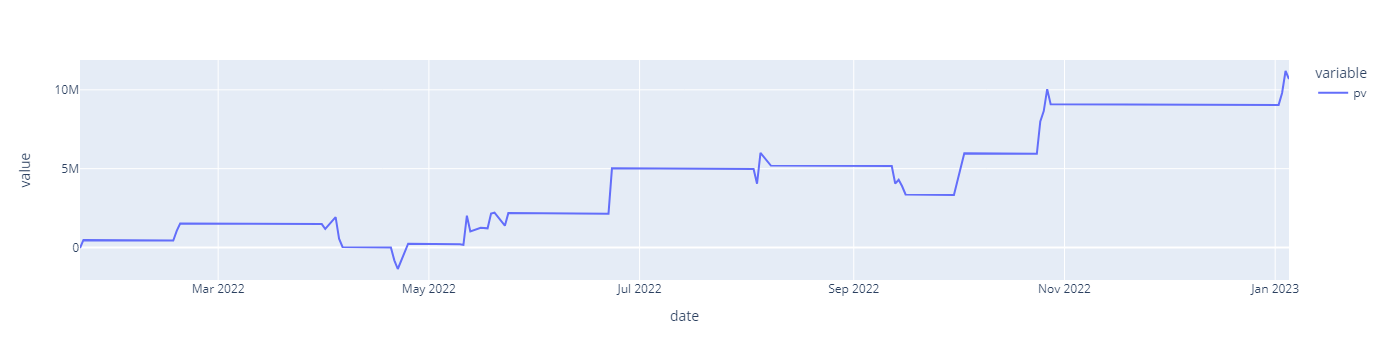

In [62]:
ress['rx1'][1].iloc[300]._pnl['pv'].plot()